# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from collections import Counter

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def entropy(y):
    # size of y
    size = len(y)
    # num of each class in y for finding p
    counts = Counter(y)
    
    return -sum(np.log(counts[key] / size) * counts[key] / size for key in counts) # entropy

In [3]:
example = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

print(round(entropy(example), 2))

0.5


Энтропия равна 0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
def gini(y):
    # size of y
    size = len(y)
    # num of each class in y for finding p
    counts = Counter(y)
    
    return sum((counts[key] / size) * (1 - counts[key] / size) for key in counts)

In [5]:
# using example array from the last task to demonstrate the work

Rm = example # [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Rl = Rm[:8]
Rr = Rm[8:]

print(round(gini(Rm) - gini(Rl) * Rl.size / Rm.size - gini(Rr) * Rr.size / Rm.size, 2))

0.32


Критерий информативности равен 0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
print(np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])) # leaf prediction

40.6


Предсказание для данных объектов будет равно 40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [7]:
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [8]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [9]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- --------------------------------------------------------------------- -————(=¤⊃)́•╮ʖ͟ ╭ರ╭(ᕕ
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- -----------------------------GOOD-LUCK------------------------------- -————(=¤⊃)́•╮ʖ͟ ╭ರ╭(ᕕ
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- --------------------------------------------------------------------- -————(=¤⊃)́•╮ʖ͟ ╭ರ╭(ᕕ
    
    
    # initilizing needed features
    thresholds, q_array, t_best, q_best = [], [], None, None
    
    # sorted unique features
    features = np.unique(feature_vector)
    
    
    # choosing thresholds depending on the feature type
    if feature_type == 'real':
        thresholds = (features[1:] + features[:-1]) / 2
        
    elif feature_type == 'categorical': 
        thresholds = features # each unique feature is a threshold
    
    
    # getting q function depending on the task
    if task == 'classification':
        
        # getting gini function for each threshold
        q = np.vectorize(lambda t: q_classification(*split_node(t, feature_vector, target_vector, feature_type)))
        
    elif task == 'regression':
        
        # getting variance function for each threshold
        q = np.vectorize(lambda t: q_regression(*split_node(t, feature_vector, target_vector, feature_type)))
    
    
    # getting q_array
    q_array = q(thresholds)
    
    # min q index
    opt_index = np.argmin(q_array)
    
    # best threshold and criterion
    t_best, q_best = thresholds[opt_index], q_array[opt_index]
    
    return thresholds, q_array, t_best, q_best


def q_classification(*args):
    
    q_func = lambda yl, yr: (gini(yl) * yl.size + gini(yr) * yr.size) / (yl.size + yr.size)
                          
    return q_func(*args) # counts gini criterion for target vector splitted by t


def q_regression(*args):
    
    q_func = lambda yl, yr: (yl.size * yl.var() + yr.size * yr.var()) / (yl.size + yr.size)
                          
    return q_func(*args) # counts variance for target vector splitted by t
                          

# function for splitting each node
def split_node(t, Rm, y, feature_type):
    
    # split depends on the feature type
    if feature_type == 'real':
        
        # mask for splitting data
        mask = Rm <= t
    
    else: # categorical feature       
        
        # mask for splitting data
        mask = Rm == t
        
    # getting needed idxs
    idx_l = np.where(mask)[0]
    idx_r = np.where(~mask)[0]

    # splitted y
    yl, yr = y[idx_l], y[idx_r]
    
    return yl, yr



thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

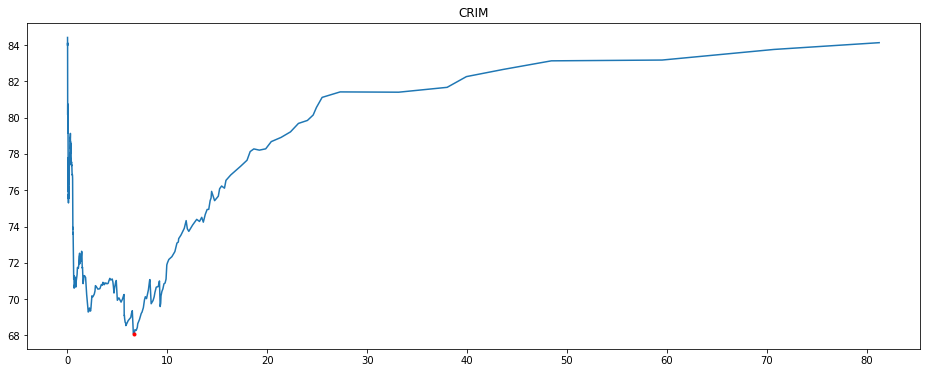

In [10]:
feature = 'CRIM'

plt.figure(figsize=(16, 6))

sns.lineplot(x=thresholds, y=variances)
plt.plot(threshold_best, variance_best, marker='.', color='r')

plt.title(feature)
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [11]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini < gini_best: # my best split is searching for minimum gini
                feature_best = feature
                gini_best = gini
                
                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- ( ͡° ͜ʖ ͡°)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- (⊙ꇴ⊙)
                else: 
                    raise ValueError
        
        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        
        # делаю реализацию только для классификации, 
        # так как постановка задачи подразумевает решение только этой задачи
        
        # если это лист, возвращаем класс
        if node['type'] == 'terminal':
            return node['class']
        
        
        # определяем тип признака и в какую сторону его отправить
        if self._feature_types[node['feature_split']] == 'real':
            
            left_condition = x[node['feature_split']] <= node['threshold']
            right_condition = x[node['feature_split']] > node['threshold']
        
        elif self._feature_types[node['feature_split']] == 'categorical':
            
            left_condition = x[node['feature_split']] == node['category_split']
            right_condition = x[node['feature_split']] != node['category_split']
        
        
        # рекурсивно прогоняем объект по дереву
        if left_condition:
            return self._predict_node(x, node['left_child'])
        
        elif right_condition:
            return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [12]:
# downloading the data
!gdown 1eoNJNEinYd0nAWCYyEWkHZQbHfsoAcpt

Downloading...
From: https://drive.google.com/uc?id=1eoNJNEinYd0nAWCYyEWkHZQbHfsoAcpt
To: C:\Users\dima1\OneDrive - НИУ Высшая школа экономики\Anaconda_Projects\Iad\students.csv

  0%|          | 0.00/7.79k [00:00<?, ?B/s]
100%|██████████| 7.79k/7.79k [00:00<?, ?B/s]


In [13]:
# load data in dataframe
data = pd.read_csv('students.csv', index_col=0)

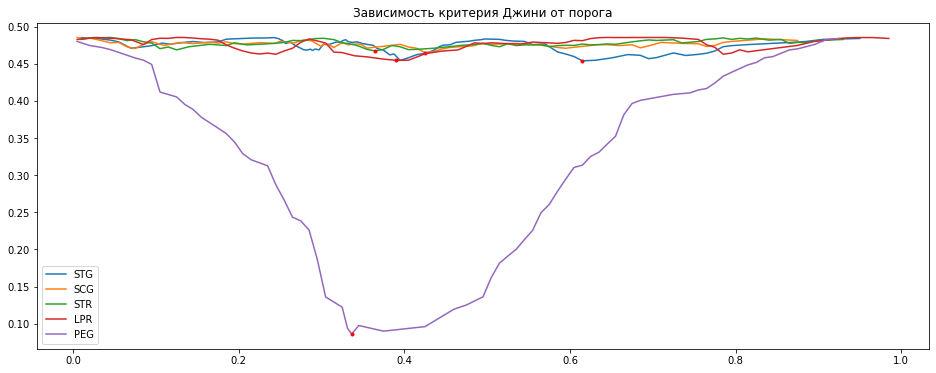

In [14]:
plt.figure(figsize=(16, 6))

# notice that all features are real
for feature in data.iloc[:, :-1].columns:
    thresholds, variances, threshold_best, variance_best = find_best_split(
        data[feature].to_numpy(), 
        data['UNS'].to_numpy(), 
        task="classification",
        feature_type="real"
    )
    
    sns.lineplot(x=thresholds, y=variances, label=feature)
    plt.plot(threshold_best, variance_best, marker='.', color='r')

plt.title('Зависимость критерия Джини от порога')
plt.show()

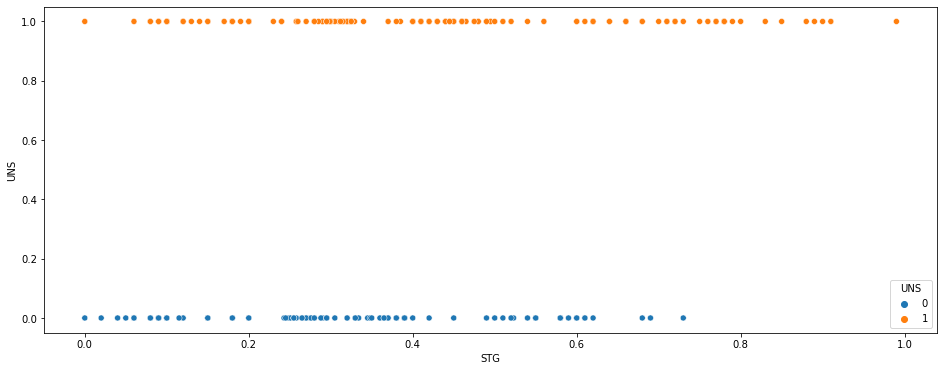

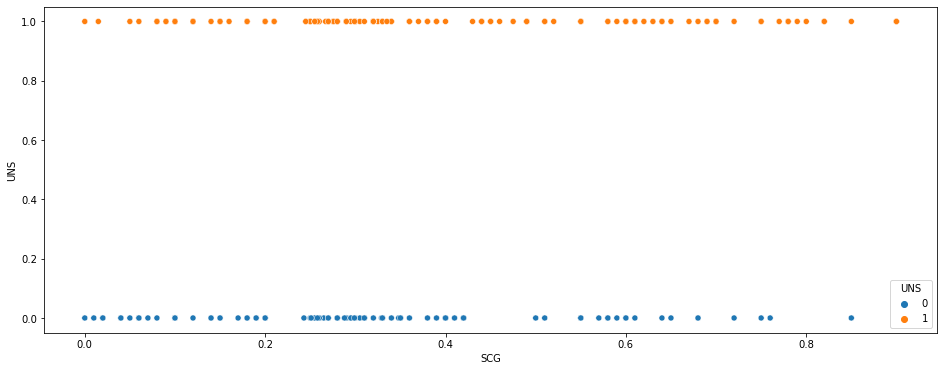

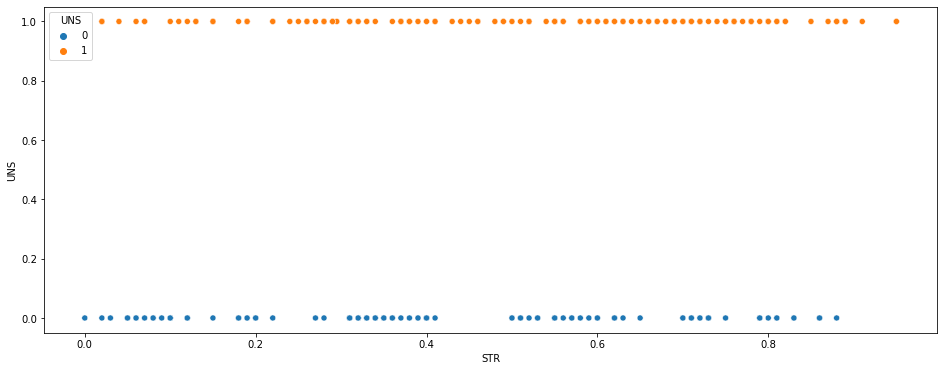

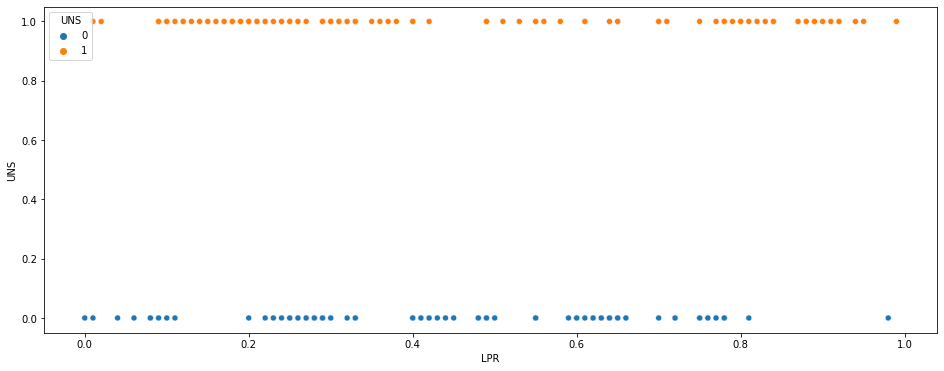

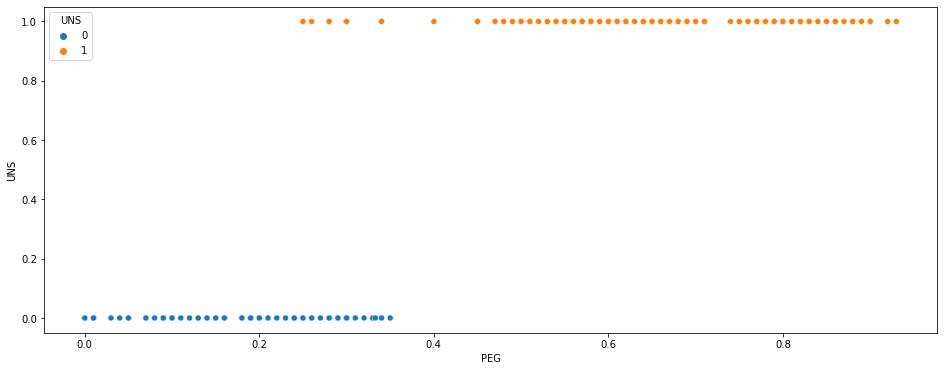

In [15]:
for feature in data.iloc[:, :-1].columns:
    plt.figure(figsize=(16, 6))
    
    sns.scatterplot(data=data, x=feature, y='UNS', hue='UNS')

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

##### Вывод

Из кривых значений критерия Джини становится очевидно, что деление выборки на два поддерева лучше всего производить по признаку PEG, так как она дает наибольший прирост информации IG = H(Rm) - H(Rl) - H(Rr). 

Этот результат согласуется с диаграммой рассеяния, так как два класса, действительно, почти идеально разделяются по этому признку при определнном пороге t. 

Кривая "хороших" признаков имеет четкий минимум, который достигается при определнном значении порога t. Выглядит, как парабола.

"Плохие" признаки, в свою очередь, выглядят, как обычные прямые, что явно дает понять, что как бы мы не делили выборку по данному признаку, мы не сможем получить большой прирост информации, то есть сильно уменьшить хаотичность в данных

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [16]:
!gdown 1xvZA6AWfwbg39JuFIPLTiC0l8dNC8k4Y

Downloading...
From: https://drive.google.com/uc?id=1xvZA6AWfwbg39JuFIPLTiC0l8dNC8k4Y
To: C:\Users\dima1\OneDrive - НИУ Высшая школа экономики\Anaconda_Projects\Iad\agaricus-lepiota.data

  0%|          | 0.00/374k [00:00<?, ?B/s]
100%|██████████| 374k/374k [00:00<00:00, 14.9MB/s]


In [17]:
data = pd.read_csv('agaricus-lepiota.data', header=None).apply(LabelEncoder().fit_transform)

X_train, X_test, y_train, y_test = train_test_split(data.drop(0, axis=1).values, data[0].values, test_size=0.5, random_state=42)

In [18]:
tree = DecisionTree(feature_types=['categorical'] * 22)
tree.fit(X_train, y_train)

prediction = tree.predict(X_test)

print(f'Accuracy score: {accuracy_score(y_test, prediction)}')

Accuracy score: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [19]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [20]:
!gdown 13rAQRIrFgim8U0KfJT-V78-pcHc35QWc

Downloading...
From: https://drive.google.com/uc?id=13rAQRIrFgim8U0KfJT-V78-pcHc35QWc
To: C:\Users\dima1\OneDrive - НИУ Высшая школа экономики\Anaconda_Projects\Iad\diabetes.csv

  0%|          | 0.00/23.1k [00:00<?, ?B/s]
100%|██████████| 23.1k/23.1k [00:00<00:00, 23.1MB/s]


In [21]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

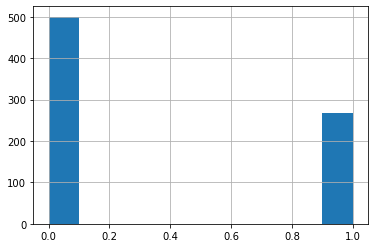

In [22]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [23]:
# train test
X_train_all, X_test, y_train_all, y_test = train_test_split(data.drop('Outcome', axis=1), data['Outcome'], test_size=0.3, random_state=42)

# train val
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [24]:
# possible hyperparameters
max_depth_array = np.arange(1, 21, 1)
min_samples_leaf_array = np.arange(1, 31, 1)

# arrays for storing results
pairs = []
scores = []

# finding best hyperparameters
for max_depth in max_depth_array:
    for min_samples_leaf in min_samples_leaf_array:
        pairs.append((max_depth, min_samples_leaf))
        
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        tree = tree.fit(X_train, y_train)
        
        prediction = tree.predict(X_val)
        score = f1_score(y_val, prediction)
        
        scores.append(score)
        
        
best_depth = pairs[np.argmax(scores)][0]
best_leaves = pairs[np.argmax(scores)][1]

print('Best parameters: {}'.format(pairs[np.argmax(scores)]))
print('Best score: {}'.format(max(scores)))

Best parameters: (7, 7)
Best score: 0.7142857142857143


In [25]:
tree = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_leaves)
tree = tree.fit(X_train_all, y_train_all)

prediction = tree.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'Precision: {precision_score(y_test, prediction)}')
print(f'Recall: {recall_score(y_test, prediction)}')
print(f'AUC ROC: {roc_auc_score(y_test, prediction)}')

Accuracy: 0.696969696969697
Precision: 0.5555555555555556
Recall: 0.625
AUC ROC: 0.6800496688741722


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [26]:
bg_clf = BaggingClassifier(n_estimators=50, random_state=42)
bg_clf = bg_clf.fit(X_train_all, y_train_all)

prediction = bg_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'Precision: {precision_score(y_test, prediction)}')
print(f'Recall: {recall_score(y_test, prediction)}')
print(f'AUC ROC: {roc_auc_score(y_test, prediction)}')

Accuracy: 0.7489177489177489
Precision: 0.6309523809523809
Recall: 0.6625
AUC ROC: 0.7286009933774835


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [27]:
# I will use this library for splitting data on folds
from sklearn.model_selection import KFold

In [28]:
np.random.seed(2)

# possible hyperparameters
max_depth_array = np.arange(1, 21, 1)
min_samples_leaf_array = np.arange(1, 31, 1)

# arrays for storing results
pairs = []
scores = []

# getting splits
kf = KFold(n_splits=3)

# finding best hyperparameters
for max_depth in max_depth_array:
    for min_samples_leaf in min_samples_leaf_array:
        
        pairs.append((max_depth, min_samples_leaf))
        
        intermediate_scores = []
        for train_index, test_index in kf.split(X_train_all):
            
            rf_clf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_jobs=-1)
            rf_clf = rf_clf.fit(X_train_all.iloc[train_index], y_train_all.iloc[train_index])
            
            prediction = rf_clf.predict(X_train_all.iloc[test_index])
            intermediate_scores.append(f1_score(y_train_all.iloc[test_index], prediction))
            
        scores.append(np.mean(intermediate_scores))
    
    
best_depth = pairs[np.argmax(scores)][0]
best_leaves = pairs[np.argmax(scores)][1]

print('Best parameters: {}'.format(pairs[np.argmax(scores)]))
print('Best score: {}'.format(max(scores)))

Best parameters: (12, 2)
Best score: 0.6873039814216285


In [29]:
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=best_depth, min_samples_leaf=best_leaves, random_state=42)
rf_clf = rf_clf.fit(X_train_all, y_train_all)

prediction = rf_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, prediction)}')
print(f'Precision: {precision_score(y_test, prediction)}')
print(f'Recall: {recall_score(y_test, prediction)}')
print(f'AUC ROC: {roc_auc_score(y_test, prediction)}')

Accuracy: 0.7445887445887446
Precision: 0.6296296296296297
Recall: 0.6375
AUC ROC: 0.719412251655629


##### Вывод

Лучше всего сработал **BaggingClassifier**, он выйграл у других моделей по всем метрикам. У меня не получилось зафиксировать обучение RandomForest ни с random seed, ни с random state, при переобучении, после перезапуска ядра, получались все равно разные значения метрик. В редких случаях RandomForest срабатывал лучше, чем BaggingClassifier

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

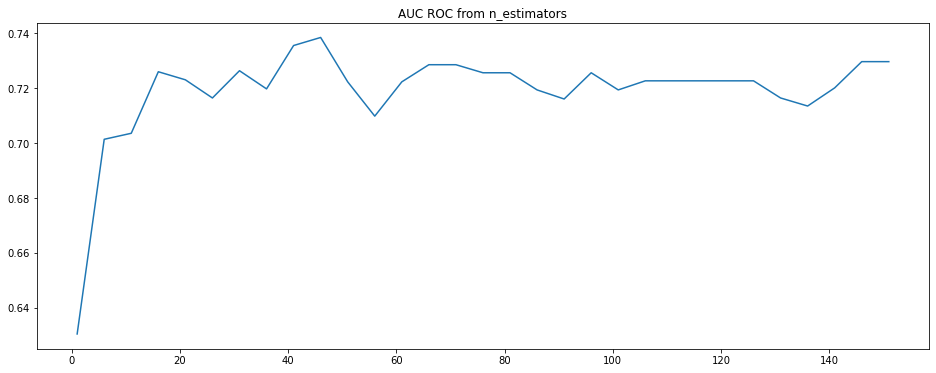

In [30]:
# hyperparameters
estimators = np.arange(1, 155, 5)

# array for storing results
scores = []

for n_estimators in estimators:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_depth, min_samples_leaf=best_leaves, random_state=42)
    rf_clf = rf_clf.fit(X_train_all, y_train_all)
    
    prediction = rf_clf.predict(X_test)
    scores.append(roc_auc_score(y_test, prediction))
    
plt.figure(figsize=(16, 6))
plt.plot(estimators, scores)
plt.title('AUC ROC from n_estimators')
plt.show()

##### Вывод

Теория о том, что RandomForest не переобучается подверждается. Видно, что при увеличении кол-ва деревьев использованных для построения RandomForest качество на тесте не падает. Можем заметить только взлет по качеству в начале, но это связано с тем, что ансамблю нужно некоторое кол-во деревьев для достижения хорошей обощающей способности

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

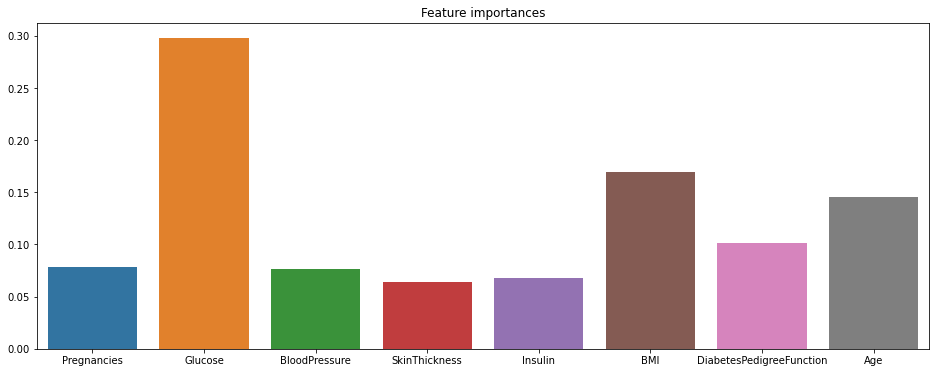

In [31]:
# the best model is RandomForest

plt.figure(figsize=(16, 6))
sns.barplot(x=X_train.columns, y=rf_clf.feature_importances_)
plt.title('Feature importances')
plt.show()

##### Вывод

Самый важным признаком оказался уровень глюкозы в крови, что вполне ожидаемо при определении диагноза диабет. Следующие по важности признаки: индекс массы тела и возраст, что соответствует обывательскому пониманию о том, что более толстые и старые люди чаще болеют диабетом